<a href="https://colab.research.google.com/github/Mugilan0909/MTP/blob/main/MTP_Mugilan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
np.__version__
import datetime

import pandas as pd
pd.__version__
import pathlib

import platform
platform.__version__
import tensorflow
tensorflow.__version__
from tensorflow import summary
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import (VGG16, ResNet50V2,
                                           InceptionResNetV2,
                                           MobileNetV2, DenseNet121)
from tensorflow.keras.layers import (Dense, Dropout, Flatten)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow.keras
tensorflow.keras.__version__
from sklearn.utils import class_weight
import sklearn
sklearn.__version__
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:

BATCH_SIZE=256 #@param {type:"number"}
HEIGHT=128 #@param {type:"number"}
WIDTH=128 #@param {type:"number"}
TRAIN="/kaggle/input/mtp-try/train/train" #@param {type:"string"}
TEST="/kaggle/input/mtp-try/test/test"


In [ ]:
# --- train data input ---
train_dir = TRAIN
train_dir = pathlib.Path(train_dir)
# --- train data input ---
test_dir = TEST
test_dir = pathlib.Path(test_dir)
image_count = len(list(train_dir.glob('*/*')))
print(image_count)

class_names = np.array([item.name for item in train_dir.glob('*')])

try:
    nclasses = len(class_names)
    print("  Found image data, proceeding.\n")
    print("   - Classes are {}".format(class_names))
except Exception:
    raise IOError("Check your data!")

img_height = HEIGHT  # image height for all images
img_width = WIDTH  # image width for all images

19997
  Found image data, proceeding.

   - Classes are ['0' '1']


In [ ]:
class_names = np.array([item.name for item in test_dir.glob('*')])

try:
    nclasses = len(class_names)
    print("  Found image data, proceeding.\n")
    print("   - Classes are {}".format(class_names))
except Exception:
    raise IOError("Check your data!")

  Found image data, proceeding.

   - Classes are ['0' '1']


In [ ]:
# tells the Generator when to stop
steps_per_epoch = np.ceil(image_count / BATCH_SIZE)

datagen = ImageDataGenerator(zoom_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rescale=1./255.)#,
                             #validation_split=VAL_SIZE)

print("\n    Fitting the training data generator:\n")
data_gen_train = datagen.flow_from_directory(
    directory=str(train_dir), batch_size=BATCH_SIZE, shuffle=True,
    target_size=(img_height, img_width), classes=["0", "1"],
    subset='training', class_mode="binary")

datagen1 = ImageDataGenerator(zoom_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rescale=1./255.)

print("\n    Fitting the validation data generator:\n")
data_gen_valid = datagen1.flow_from_directory(
    directory=str(test_dir), batch_size=BATCH_SIZE, shuffle=True,
    target_size=(img_height, img_width), classes=["0", "1"],
    subset='training', class_mode="binary")


    Fitting the training data generator:

Found 19997 images belonging to 2 classes.

    Fitting the validation data generator:

Found 1200 images belonging to 2 classes.


In [ ]:
import tqdm
data_gen_train.reset()
x_train, y_train = next(data_gen_train)
for i in tqdm.tqdm(range(70,int(data_gen_train.n/BATCH_SIZE)-1)): 
  img, label = next(data_gen_train)
  x_train = np.append(x_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|██████████| 7/7 [00:19<00:00,  2.81s/it]

(2048, 128, 128, 3) (2048,)


In [ ]:
import tqdm
data_gen_valid.reset()
x_test, y_test = next(data_gen_valid)
for i in tqdm.tqdm(range(int(data_gen_valid.n/BATCH_SIZE)-1)): 
  img, label = next(data_gen_valid)
  x_test = np.append(x_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(x_test.shape, y_test.shape)

100%|██████████| 3/3 [00:06<00:00,  2.25s/it]

(1024, 128, 128, 3) (1024,)


In [ ]:
num_classes = 2
input_shape = (128, 128, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


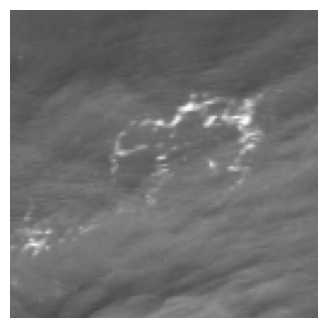

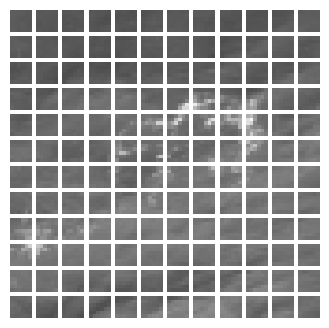

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),try1
        ]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    
    

    

    model.load_weights(checkpoint_filepath)

    _, accuracy, top_5_accuracy,_ = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

(None, 1)
(None, 2)
(None, 1)
(None, 2)
1/8 [==>...........................] - ETA: 2:11 - loss: 1.5309 - accuracy: 0.5039 - top-5-accuracy: 1.0000 - try1: 0.0000e+00

KeyboardInterrupt: 

0
